In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, MaxAbsScaler
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib as mpl
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)


In [ ]:
url = "https://drive.google.com/uc?export=download&id=1fVdFJZN86Y1peVbFIN4cC7_Uw6cVtyac"
df = pd.read_csv(url, sep=',')
df

,name,artists,danceability,energy,loudness,acousticness,liveness,valence,tempo
0,Yellow,Coldplay,0.429,0.661,-7.227,0.00239,0.2340,Negative,173.372
1,Without Me,Eminem,0.908,0.669,-2.827,0.00286,0.2370,Positive,112.238
2,Heartless,Kanye West,0.790,0.647,NaN,0.05150,0.2480,Positive,87.999
3,Mr. Brightside,The Killers,0.352,0.911,-5.230,0.00121,0.0995,Very negative,148.033
4,In the End,Linkin Park,0.556,0.864,-5.870,0.00958,0.2090,Negative,105.143
...,...,...,...,...,...,...,...,...,...
145,"Valerie - Live At BBC Radio 1 Live Lounge, Lon...",Amy Winehouse,0.772,0.371,-5.743,0.74400,0.1670,Positive,96.574
146,Feel,Robbie Williams,0.599,0.732,NaN,0.01450,0.1430,Negative,97.997
147,L'Amour Toujours,Gigi D'Agostino,0.638,0.877,NaN,0.07710,0.3640,Positive,NaN
148,Fallin',Alicia Keys,0.652,0.609,-7.519,NaN,0.2330,Neutral,95.986


## FUNCIONES AUX

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

def plot_silhouette(model, X):
    mu = model.cluster_centers_
    K, D = mu.shape
    y_pred = model.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_scores = silhouette_score(X, model.labels_)
    cmap = plt.get_cmap("Pastel2")
    colors = [cmap(i) for i in range(K)]
    padding = len(X) // 30
    pos = padding
    for i in range(K):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / K)
        # color = colors[i]
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        pos += len(coeffs) + padding
    score = silhouette_scores
    plt.axvline(x=score, color="red", linestyle="--")
    plt.title("$k={}, score={:0.2f}$".format(K, score), fontsize=16)

def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="o", s=30, linewidths=8, color=circle_color, zorder=10, alpha=0.9
    )
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="x", s=50, linewidths=50, color=cross_color, zorder=11, alpha=1
    )

def plot_decision_boundaries(model, X, resolution=1000):
    mu = model.cluster_centers_
    K, D = mu.shape
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # cmap = [mpl.cm.Spectral( (i / K)) for i in range(K)]
    cmap = "Pastel2"
    # cmap = mpl.cm.Spectral(K)
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap=cmap)
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k")
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    plot_centroids(model.cluster_centers_)
    plt.title(f"K={K}")

def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # Primer cuartil (Q1)
    Q3 = df[column].quantile(0.75)  # Tercer cuartil (Q3)
    IQR = Q3 - Q1  # Rango intercuartílico

    # Definir límites inferior y superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar los outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return outliers

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# **PREPROCESADO**


##TRATAMIENTO OUTLIERS

Miramos la presencia de outliers

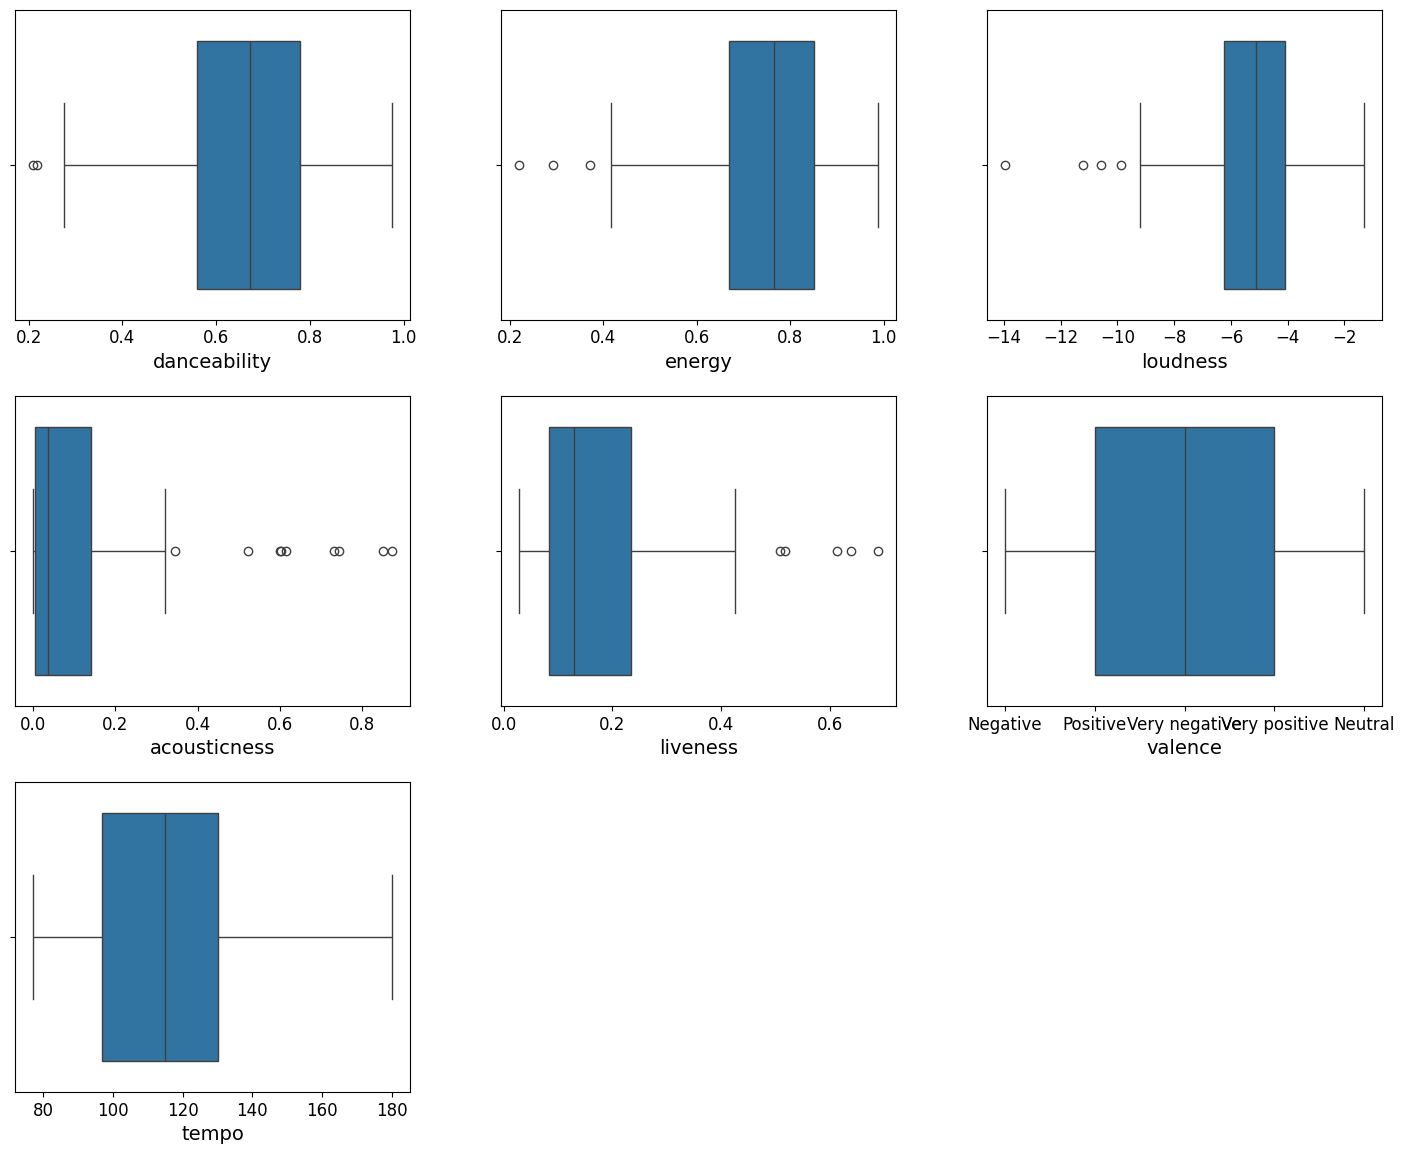

In [ ]:
columns =  ['danceability', 'energy', 'loudness', 'acousticness', 'liveness','valence', 'tempo']
# Definir el número de filas y columnas para los subplots
num_cols = 7
num_rows = 3

# Crear subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*4))  # 3 subplots por fila

# Ajustar el layout
fig.tight_layout(pad=3.0)

# Graficar cada columna en un subplot
for i, col in enumerate(columns):
    row = i // 3
    col_pos = i % 3
    sns.boxplot(x=df[col], ax=axes[row, col_pos])

# Eliminar los subplots vacíos si hay
if num_cols % 3 != 0:
    for j in range(num_cols % 3, 3):
        fig.delaxes(axes[-1, j])

plt.show()

Vemos que hay claramente outliers en tempo. Vamos a averiguar si es debido a un error de transcripción

In [ ]:
identify_outliers(df,'tempo')

,name,artists,danceability,energy,loudness,acousticness,liveness,valence,tempo


Hemos buscado através de la spotify api que los datos verdaderos de tempo en 'The Next Episode' y 'All the things she said' son realmente  95.295 y 179.92 respectivamente. Por lo q vamos a sustituir estos datos ya que se tratan de errores de transcripción.


In [ ]:
# Cambiar el valor del 'tempo' para "The Next Episode"
df.loc[df['name'] == 'The Next Episode', 'tempo'] = 95.295

# Cambiar el valor del 'tempo' para "All The Things She Said"
df.loc[df['name'] == 'All The Things She Said', 'tempo'] = 179.92

##SELECCIÓN FINAL

Después de haber deliberado para cuales son nuestras mejores opciones para nuestros datos hemos optado por el preprocesado con el OrdinalEncoder junto al SimpleImputer de la Media y MaxAbsScaler:

In [ ]:
# Definimos el pipeline solo con los pasos de preprocesamiento
pipe = make_pipeline(
    SimpleImputer(strategy='mean'),  # Imputación con la media
    MaxAbsScaler()  # Escalado MaxAbsScaler
)

In [ ]:
X = df[['danceability', 'energy', 'loudness', 'acousticness', 'liveness', 'valence', 'tempo']]

# Cambiamos de variables categóricas a numéricas
ordinal_encoder = OrdinalEncoder(categories=[['Very negative', 'Negative', 'Neutral', 'Positive', 'Very positive']])
X.loc[:, 'valence'] = ordinal_encoder.fit_transform(X[['valence']])

# Aplicamos el pipeline de preprocesamiento
X = pipe.fit_transform(X)
print(X)

[[ 0.44        0.66902834 -0.51754512 ...  0.33962264  0.25
   0.96256815]
 [ 0.93128205  0.67712551 -0.20244915 ...  0.34397678  0.75
   0.62314978]
 [ 0.81025641  0.6548583  -0.38169376 ...  0.35994194  0.75
   0.4885739 ]
 ...
 [ 0.65435897  0.88765182 -0.38169376 ...  0.52830189  0.75
   0.65983369]
 [ 0.66871795  0.61639676 -0.53845603 ...  0.33817126  0.5
   0.53291804]
 [ 0.75897436  0.77530364 -0.21046978 ...  0.05892598  1.
   0.94679481]]


Hemos pasado X a df para hacer más adelante pruebas con nuestro dataset

In [ ]:
column_names = ['danceability', 'energy', 'loudness', 'acousticness', 'liveness', 'valence', 'tempo']  # Nombres de columnas de tu df
X_df = pd.DataFrame(X, columns=column_names)

# **CLUSTERS**

##KMEANS

Asignamos un rango de clusters para ver el número óptimo de clusters usando k-means

In [ ]:
Ks = range(1,20)
kmeans_per_k = [KMeans(n_clusters=k, n_init=100).fit(X) for k in Ks]

Estudiamos la inertia y aplicamos la regla del codo

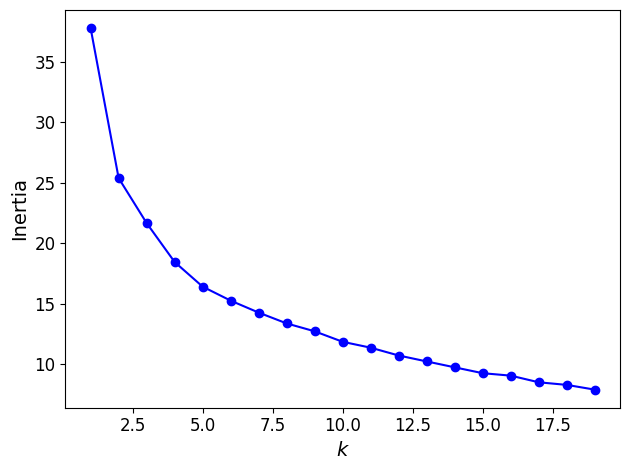

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure()
plt.plot(Ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.tight_layout()
plt.show()

Calculamos el silhouette score para diferentes números de clusters(siendo los mejores K=2 o K=3)

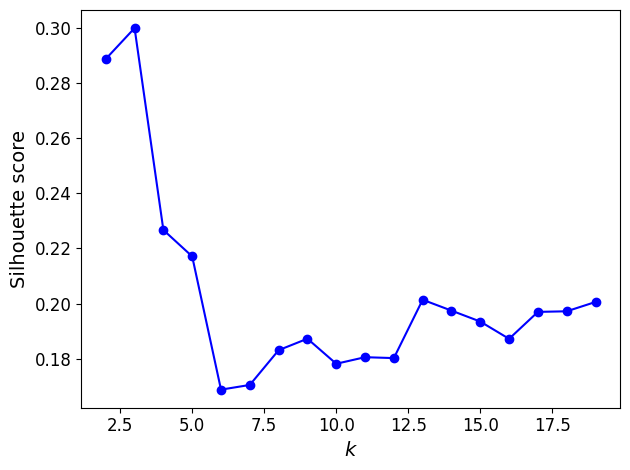

In [ ]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure()
plt.plot(Ks[1:], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.tight_layout()
plt.show()

Elegimos K=3 y vemos el silhoutte de los datos en los clusters

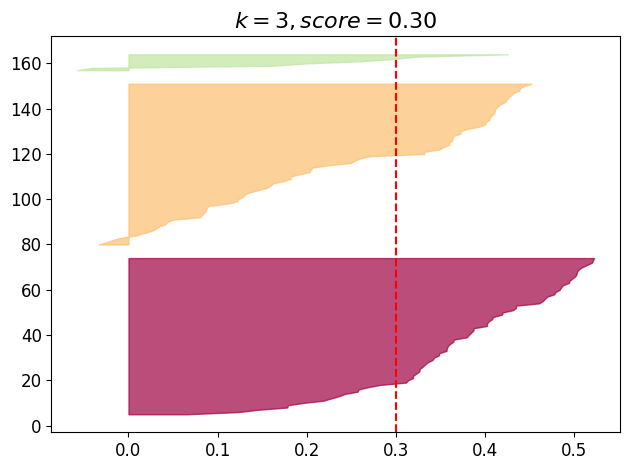

In [ ]:
model = kmeans_per_k[2]
plt.figure()
plot_silhouette(model, X)
plt.tight_layout()

## CLUSTERING JERÁRQUICO

Hacemos un scatter plot para visualizar los datos

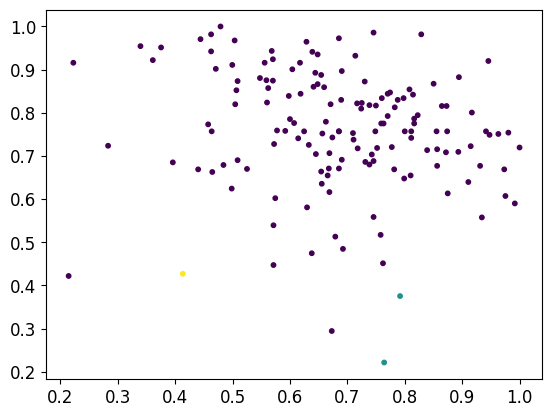

In [ ]:
clustering = AgglomerativeClustering(n_clusters=3, linkage = 'single').fit(X)
# clustering = AgglomerativeClustering(n_clusters=2, linkage = 'complete').fit(X) #Probar más linkage
plt.scatter(X[:, 0], X[:, 1], s=10, c=clustering.labels_)
plt.show()

Para seleccionar adecuadamente el número de clusters, visualizamos diferentes dendrogramas variando los linkage y las métricas de afinidad

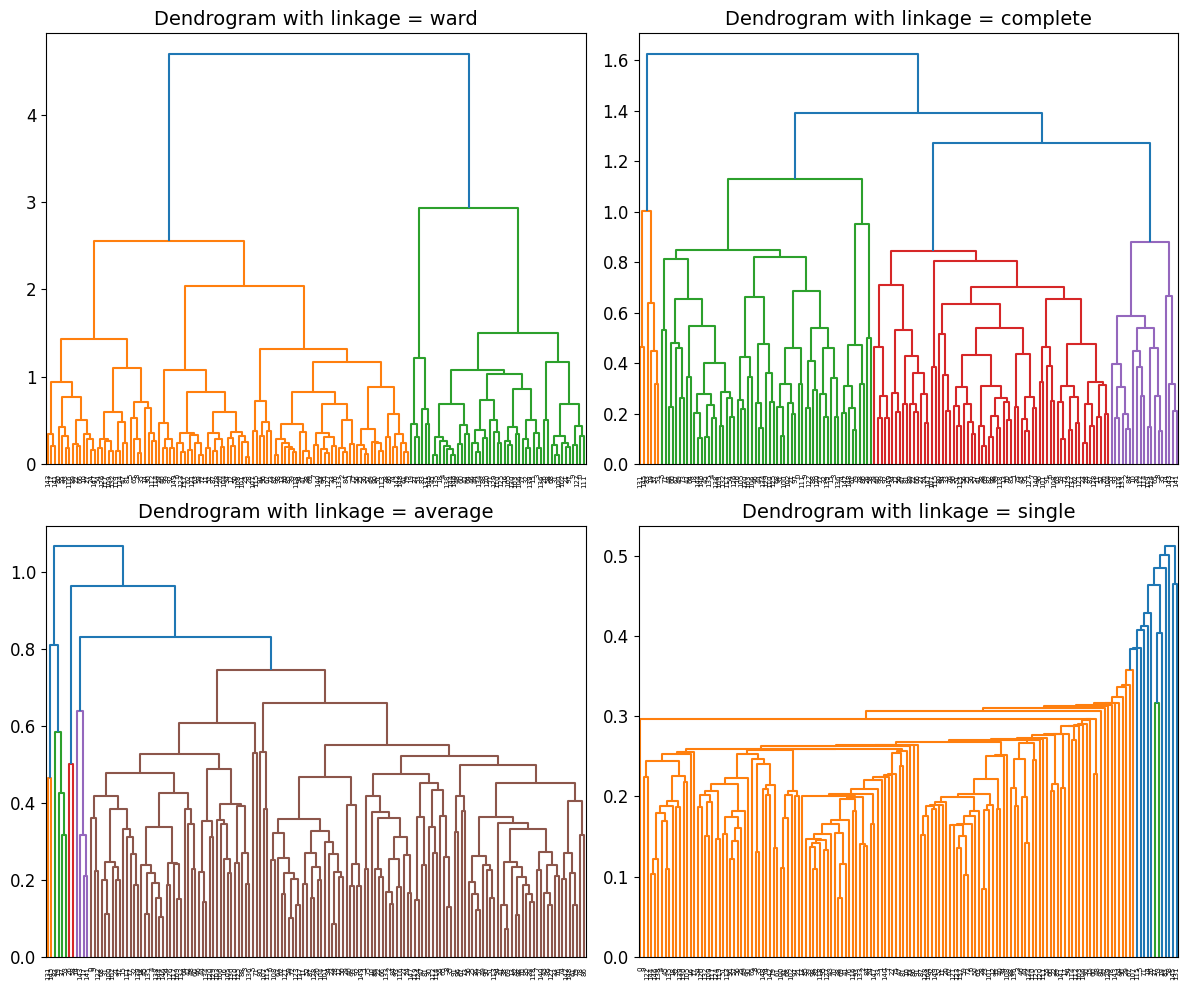

In [ ]:
linkage_types = ['ward', 'complete', 'average', 'single']

# Crear una figura con 2 filas y 2 columnas
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Iterar por cada tipo de linkage y generar el dendrograma en su respectivo subplot
for i, linkage_type in enumerate(linkage_types):
    # Ajustar el clustering jerárquico
    clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage_type).fit(X)

    # Elegir la ubicación del subplot (2x2)
    ax = axs[i // 2, i % 2]

    # Crear el dendrograma utilizando tu función plot_dendrogram
    plot_dendrogram(clustering, ax=ax)

    # Añadir el título
    ax.set_title(f"Dendrogram with linkage = {linkage_type}", fontsize=14)

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()



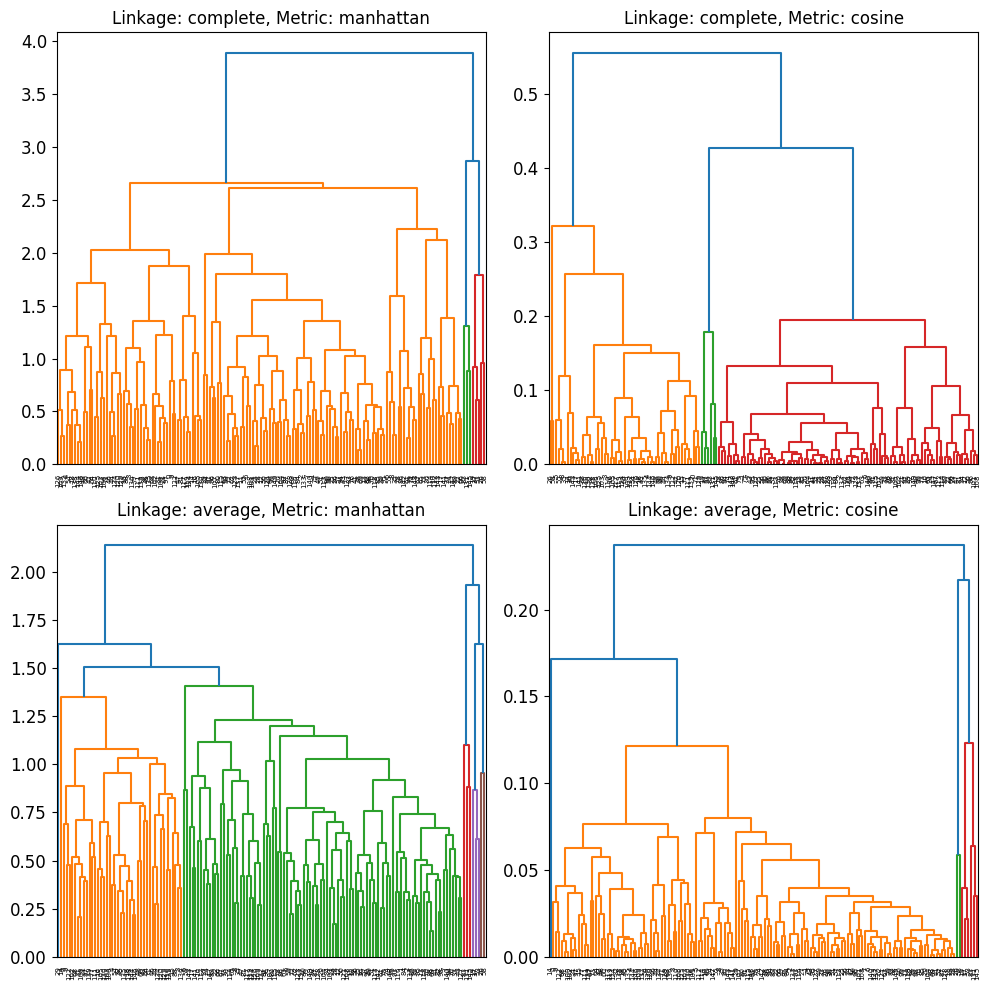

In [ ]:
# Definir los linkage types y las métricas que queremos probar
linkage_types = ['complete', 'average']
metrics = ['manhattan', 'cosine']

# Crear una figura con una cuadrícula de 2x2 para las gráficas
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()  # Aplanar el array de ejes para iterar fácilmente

# Definir una función para plotear el dendrograma
def plot_dendrogram(model, **kwargs):
    # Crear el dendrograma
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Un nodo hoja
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Crear el dendrograma
    dendrogram(linkage_matrix, **kwargs)

# Iterar por cada combinación de linkage type y métrica
for i, (linkage, metric) in enumerate([(l, m) for l in linkage_types for m in metrics]):
    # Ajustar el clustering jerárquico
    clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage, metric=metric).fit(X)

    # Seleccionar el subplot actual
    ax = axes[i]

    # Crear el dendrograma en el subplot actual
    plot_dendrogram(clustering, ax=ax)

    # Añadir el título al subplot
    ax.set_title(f'Linkage: {linkage}, Metric: {metric}', fontsize=12)

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()



Elegimos el clustering jerarquico con linkage completo y métrica euclideana porque creemos que es el que mas se adecúa a nuestro dataset

Hacemos una serie de pruebas para evaluar la calidad de nuestro clustering

In [ ]:
clustering_complete = AgglomerativeClustering(n_clusters=4, linkage = 'complete').fit(X)
df_complete = df.copy()  # Copia del dataframe para el clustering de 'ward'
df_complete['cluster'] = clustering_complete.labels_

df_complete[df_complete['artists'] == 'Linkin Park']

,name,artists,danceability,energy,loudness,acousticness,liveness,valence,tempo,cluster
4,In the End,Linkin Park,0.556,0.864,-5.870,0.00958,0.209,Negative,105.143,0
14,Numb,Linkin Park,0.496,0.863,-4.153,0.00460,0.639,Negative,110.018,2
45,What I've Done,Linkin Park,0.623,0.930,-5.285,0.01410,0.138,Negative,120.119,0


Hacemos gráficas para ver las características de cada uno de los clusters (usando la media de las variables)

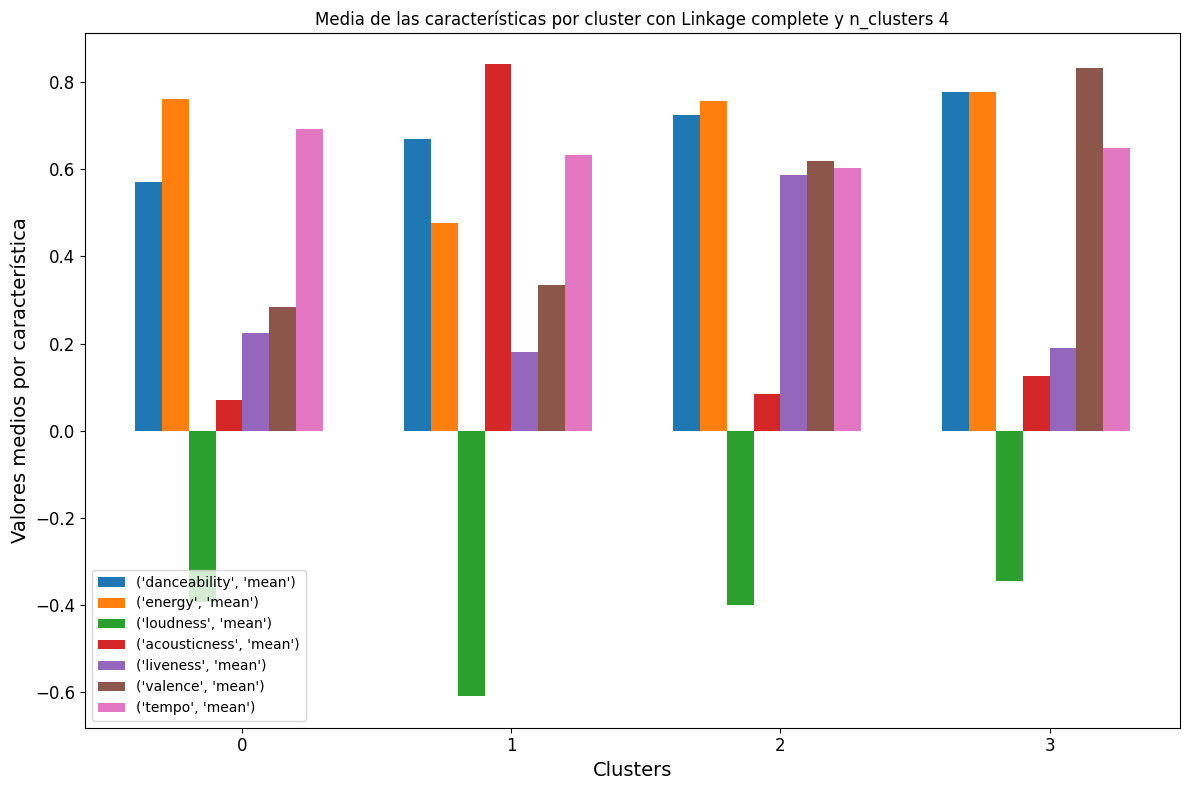

In [ ]:
clustering_complete = AgglomerativeClustering(n_clusters=4, linkage = 'complete').fit(X)
X_df_complete = X_df.copy()  # Copia del dataframe para el clustering de 'ward'
X_df_complete['cluster'] = clustering_complete.labels_

summary_by_cluster = X_df_complete.groupby('cluster').agg(['mean'])
means = summary_by_cluster

# Crear el gráfico de barras para cada cluster
clusters = means.index
features = means.columns

x = np.arange(len(clusters))  # Localización para las etiquetas en el eje x
width = 0.1  # El ancho de las barras

fig, ax = plt.subplots(figsize=(12, 8))

# Para cada característica, dibujar una barra para cada cluster
for i, feature in enumerate(features):
    ax.bar(x + i * width, means[feature], width, label=f'{feature}')

# Añadir etiquetas y títulos
ax.set_xlabel('Clusters')
ax.set_ylabel('Valores medios por característica')
ax.set_title('Media de las características por cluster con Linkage complete y n_clusters 4')
ax.set_xticks(x + width * len(features) / 2)
ax.set_xticklabels(clusters)
ax.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [ ]:
df_complete[df_complete['cluster']==2].head()

,name,artists,danceability,energy,loudness,acousticness,liveness,valence,tempo,cluster
2,Heartless,Kanye West,0.790,0.647,NaN,0.05150,0.248,Positive,87.999,2
8,Flashing Lights,"Kanye West, Dwele",0.639,0.628,-7.578,0.03810,0.386,Neutral,90.482,2
10,Hips Don't Lie (feat. Wyclef Jean),"Shakira, Wyclef Jean",0.778,0.824,-5.892,0.28400,0.405,Positive,100.024,2
14,Numb,Linkin Park,0.496,0.863,-4.153,0.00460,0.639,Negative,110.018,2
17,Feel Good Inc.,Gorillaz,0.818,0.705,-6.679,0.00836,0.613,Positive,138.559,2


Hemos hecho un pequeño estudio con linkage ward y nos damos cuenta que son clusters que generalizan demasiado

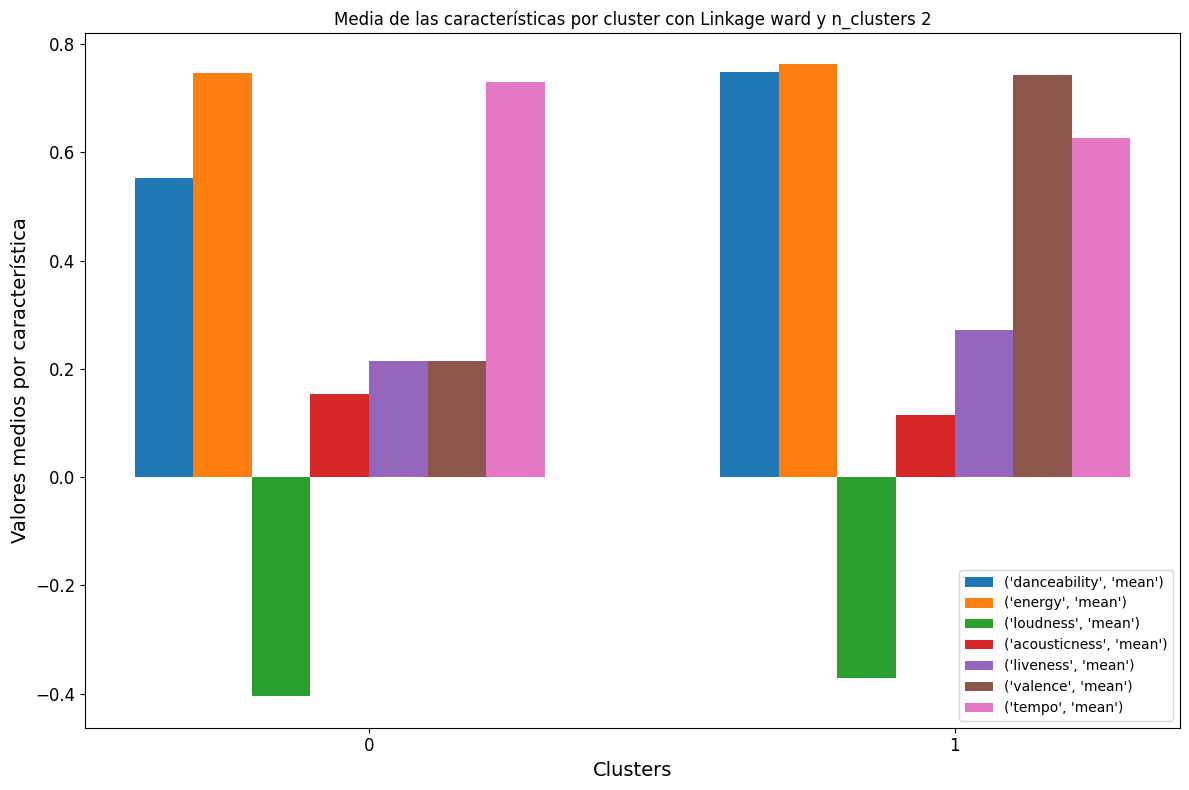

In [ ]:
# Aplicar clustering jerárquico con linkage = 'ward' y n_clusters = 2
clustering_ward = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(X)
X_df_ward = X_df.copy()  # Copia del dataframe para el clustering de 'ward'
X_df_ward['cluster'] = clustering_ward.labels_

# Calcular las estadísticas descriptivas solo para las columnas numéricas
summary_by_cluster_ward = X_df_ward.groupby('cluster').agg(['mean'])

means_ward = summary_by_cluster_ward

# Crear el gráfico de barras para cada cluster
clusters_ward = means_ward.index
features_ward = means_ward.columns

x = np.arange(len(clusters_ward))  # Localización para las etiquetas en el eje x
width = 0.1  # El ancho de las barras

fig, ax = plt.subplots(figsize=(12, 8))

# Para cada característica, dibujar una barra para cada cluster
for i, feature in enumerate(features_ward):
    ax.bar(x + i * width, means_ward[feature], width, label=f'{feature}')

# Añadir etiquetas y títulos
ax.set_xlabel('Clusters')
ax.set_ylabel('Valores medios por característica')
ax.set_title('Media de las características por cluster con Linkage ward y n_clusters 2')
ax.set_xticks(x + width * len(features_ward) / 2)
ax.set_xticklabels(clusters_ward)
ax.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()



Vemos que prácticamente solo se diferencian en la valencia

##DBSCAN

Hacemos un bucle para hallar los valores óptimos para inicializar DBScan(eps y min_sample)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Rango de valores de eps y min_samples para probar
eps_values = np.linspace(0.15, 0.3, 100)  # Valores de eps entre 0.15 y 0.3
min_samples_values = range(1, 10)  # Valores de min_samples entre 1 y 10

# Guardar los resultados
results = []

# Hacer un bucle por diferentes combinaciones de eps y min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

        # Obtener las etiquetas de los clusters
        labels = dbscan.labels_

        # Contar el número de clusters (ignorar los puntos considerados ruido, etiquetados como -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Calcular el Silhouette Score si hay más de 1 cluster
        if n_clusters > 1:
            silhouette_avg = silhouette_score(X, labels)
        else:
            silhouette_avg = -1  # No calculable si no hay suficientes clusters

        # Guardar los resultados
        results.append((eps, min_samples, n_clusters, silhouette_avg))

# Convertir los resultados en un dataframe para visualizar
df_results = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'silhouette_avg'])

# Filtrar solo los casos con un Silhouette Score válido (mayor que -1)
df_filtered = df_results[df_results['silhouette_avg'] > -1]

# Obtener el valor máximo de silhouette_avg
max_silhouette = df_filtered['silhouette_avg'].max()
df_filtered[df_filtered['silhouette_avg']==max_silhouette]




,eps,min_samples,n_clusters,silhouette_avg
876,0.29697,4,2,0.127279


Una vez encontrado los valores óptimos, hacemos plots con eps y min_samoles parecidos

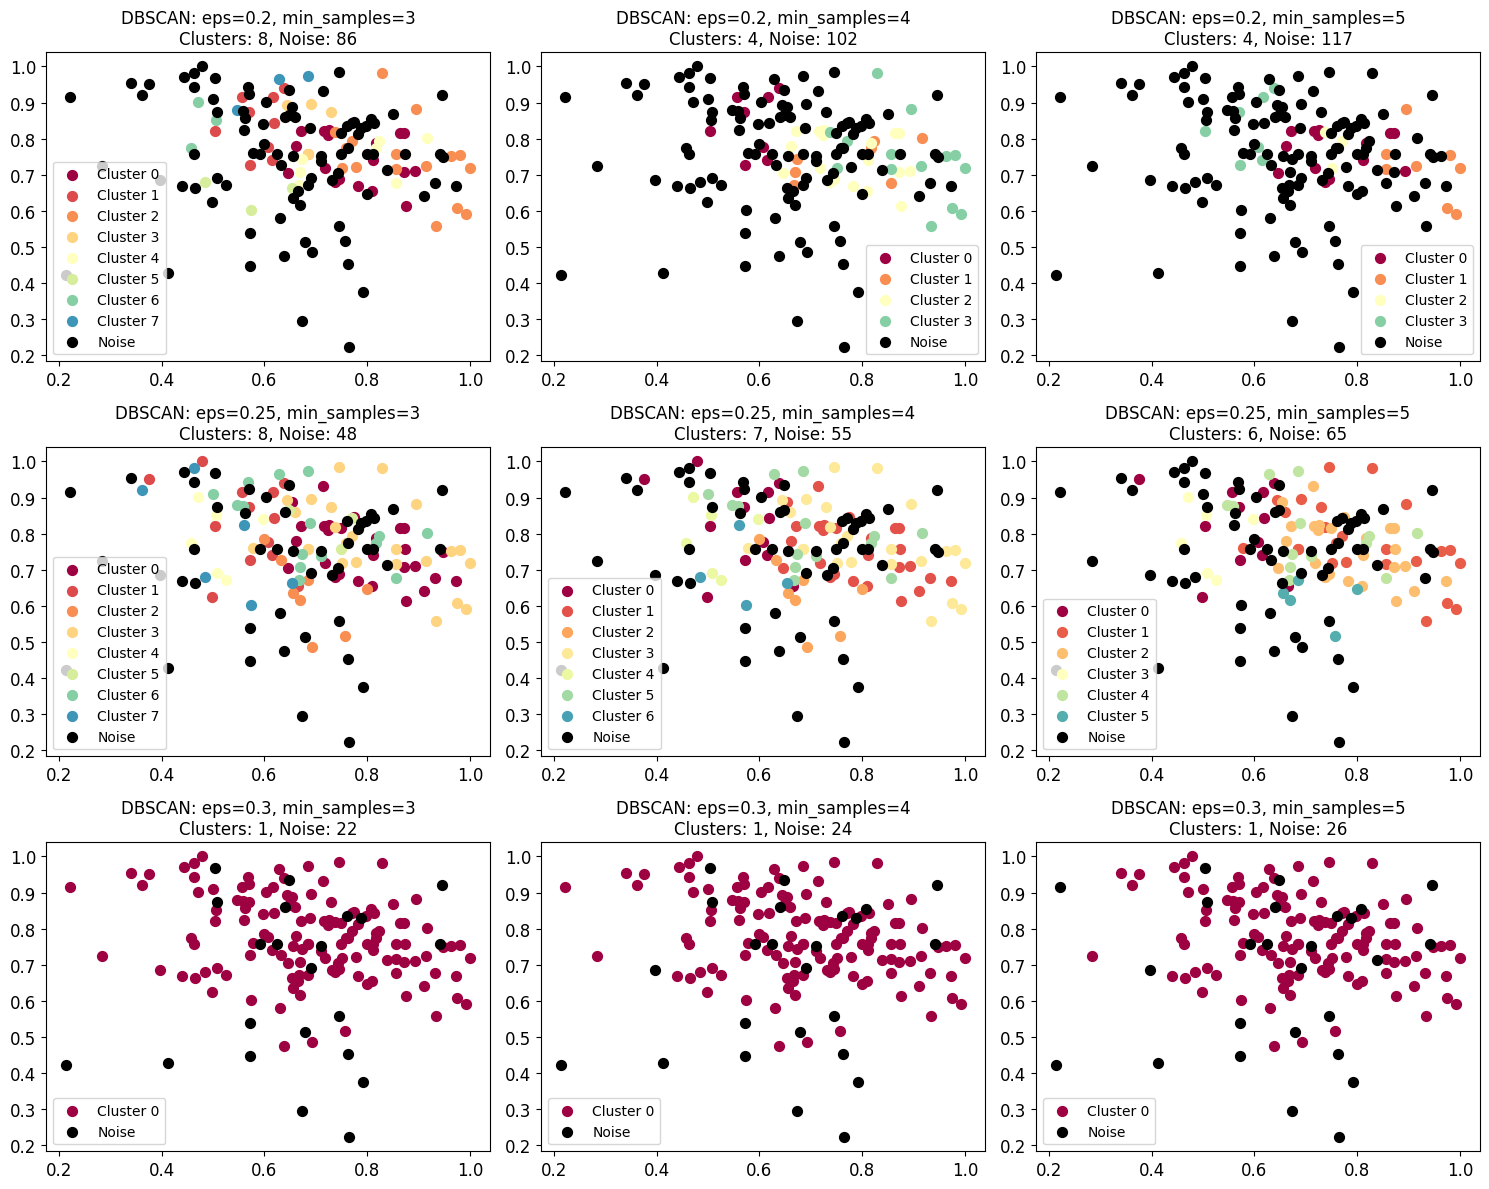

In [ ]:
# Valores de eps y min_samples para probar
eps_values = [0.2, 0.25, 0.3]  # 3 valores diferentes de eps
min_samples_values = [3, 4, 5]  # 3 valores diferentes de min_samples

# Crear una figura con una cuadrícula 3x3 para las gráficas
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()  # Para poder iterar sobre los subplots fácilmente

# Hacer un bucle por las combinaciones de eps y min_samples
for idx, (eps, min_samples) in enumerate([(e, ms) for e in eps_values for ms in min_samples_values]):
    # Aplicar DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

    # Obtener las etiquetas de los clusters
    labels = dbscan.labels_

    # Contar el número de clusters (ignorar los puntos considerados ruido, etiquetados como -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # Graficar los resultados
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    ax = axes[idx]  # Seleccionar el subplot actual

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Color para el ruido (negro)
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        # Graficar puntos del cluster
        xy = X[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], label=f'Cluster {k}' if k != -1 else 'Noise')

    # Añadir el título con los parámetros
    ax.set_title(f'DBSCAN: eps={eps}, min_samples={min_samples}\nClusters: {n_clusters}, Noise: {n_noise}')
    ax.legend(loc='best')

# Ajustar el layout de la figura
plt.tight_layout()
plt.show()




Vemos que los resultados no son los mejores, por tanto decidimos no seguir analizando el clustering por DBScan

# **Extras**

##PCA

Hacemos una matriz de correlación entre las variables para estudiar una posible reducción de dimensionalidad

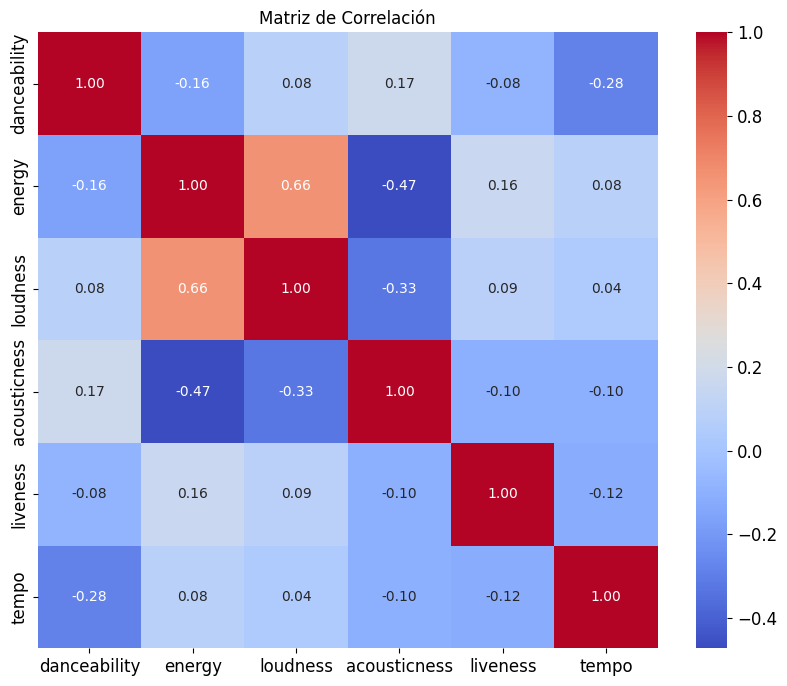

In [ ]:
# Supongamos que tu DataFrame se llama df y contiene tus variables cuantitativas
df_quant = df[['danceability', 'energy', 'loudness', 'acousticness', 'liveness', 'tempo']]

# Calcular la matriz de correlaciones
correlation_matrix = df_quant.corr(method='pearson')

# Visualizar la matriz de correlaciones usando un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


Calculamos y graficamos la variabilidad acumulada

Varianza explicada por cada componente principal: [0.38377037 0.19402711 0.1656433  0.09761411 0.07155222 0.06120269
 0.0261902 ]
Varianza acumulada explicada: [0.38377037 0.57779748 0.74344078 0.84105489 0.9126071  0.9738098
 1.        ]


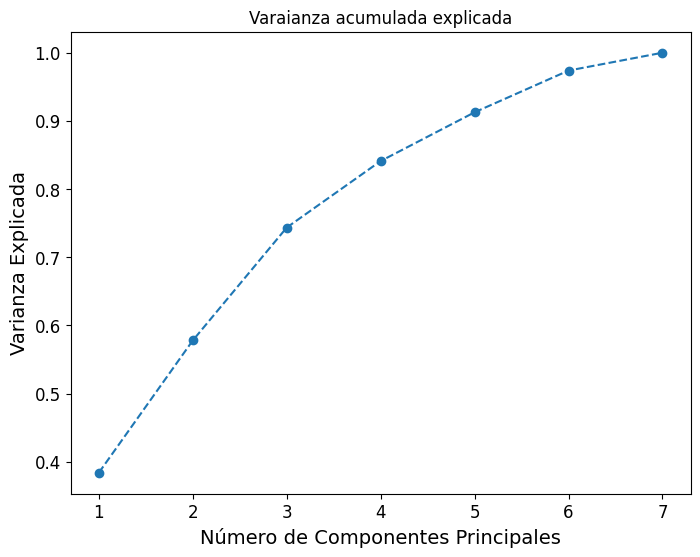

In [ ]:
from sklearn.decomposition import PCA

# Supongamos que tienes un DataFrame 'df' con las columnas cuantitativas y categóricas
X = df[['danceability', 'energy', 'loudness', 'acousticness', 'liveness', 'valence', 'tempo']]

# 1. Convertir la variable categórica 'valence' a numérica usando OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['Very negative', 'Negative', 'Neutral', 'Positive', 'Very positive']])
X.loc[:, 'valence'] = ordinal_encoder.fit_transform(X[['valence']])

# 2. Rellenar los valores faltantes (NaN) con la media de cada columna
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

# 3. Escalar los datos usando MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 4. Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=None)  # None significa que calcularemos todos los componentes principales
X_pca = pca.fit_transform(X_scaled)

# Mostrar la varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente principal: {explained_variance}')

# 5. Calcular la varianza acumulada explicada
cumulative_explained_variance = np.cumsum(explained_variance)
print(f'Varianza acumulada explicada: {cumulative_explained_variance}')

# 5. Crear el scree plot (gráfico de sedimentos) para visualizar la varianza explicada
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Varaianza acumulada explicada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.show()

Vemos que necesitamos 5/7 variables para explicar el 90% de la variabilidad, creemos que perdemos explicabilidad de las variables sin reducir demasiado la dimensionalidad

##PREDICCIÓN

Usaremos los clusters obtenidos en el clustering jerarquico para hacer clasificación y predicción.

In [ ]:
# Separar las características y el objetivo (cluster)
y = X_df_complete['cluster']
X = X_df_complete.drop(columns=['cluster'])

Dividir los datos en entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,danceability,energy,loudness,acousticness,liveness,valence,tempo
22,0.748718,0.757099,-0.378187,0.002683,0.452830,1.00,0.651310
15,0.562051,0.857287,-0.231810,0.071330,0.118433,0.00,0.951880
65,0.600000,0.785425,-0.422372,0.065596,0.435414,0.50,0.432987
11,0.828718,0.981781,-0.436694,0.065252,0.223512,1.00,0.634754
42,0.941538,0.757099,-0.403896,0.106422,0.201742,0.25,0.710705
...,...,...,...,...,...,...,...
71,0.709744,0.753036,-0.326912,0.009954,0.521045,0.00,0.951475
106,0.462564,0.942308,-0.277213,0.000872,0.523948,0.00,0.682684
14,0.508718,0.873482,-0.297408,0.005275,0.927431,0.25,0.610824
92,0.777436,0.720648,-0.270768,0.021216,0.098258,1.00,0.832795


In [ ]:
# Entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# Predecir en el conjunto de prueba
y_pred = knn.predict(X_test)

# Evaluar la accuracy del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo: {accuracy}')

Precisión del modelo: 0.9333333333333333


Predecimos el cluster al que pertenece la canción Happy de Pharrel Williams

In [ ]:
nueva_cancion = [[0.647, 0.822, -4.662, 0.219, 0.0908, 4, 160.019]] #Very positive está codificado como un 4 #La cancion es Happy Pharrel Williams

# Aplicamos el pipeline de preprocesamiento a la nueva canción
nueva_cancion_escalada = pipe.transform(nueva_cancion)

print(nueva_cancion_escalada)


[[ 0.66358974  0.83198381 -0.33385849  0.25114679  0.1317852   1.
   0.88843177]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [ ]:
cluster_predicho = knn.predict(nueva_cancion_escalada)
print(f"La nueva canción pertenece al cluster: {cluster_predicho[0]}")

La nueva canción pertenece al cluster: 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
